In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import time
import artm

# change log style
lc = artm.messages.ConfigureLoggingArgs()
lc.minloglevel = 3
lib = artm.wrapper.LibArtm(logging_config=lc)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
from copy import deepcopy
from topicnet.cooking_machine.models.topic_model import TopicModel
from topicnet.cooking_machine.cubes import RegularizersModifierCube
from topicnet.cooking_machine.config_parser import build_experiment_environment_from_yaml_config
from topicnet.cooking_machine.experiment import Experiment
from topicnet.cooking_machine.cubes import *
from topicnet.cooking_machine.dataset import Dataset
from topicnet.cooking_machine.pretty_output import make_notebook_pretty
make_notebook_pretty()

In [3]:
import topicnet.cooking_machine.cubes as tncubes

In [4]:
from IPython.core.display import display, HTML
from IPython.display import clear_output, display_html
display(HTML("""<style>
.container { width:90% !important; }
div.output_scroll .output_subarea { white-space: pre; }
</style>"""))

### Make initial model

In [5]:
with open("./exploratory_search.yml", "r") as f:
    yaml_string = f.read()

DATASET_PATH = "Pscience.csv"
specific_topics = [f'topic_{i}' for i in range(35)]
background_topics = [f'bcg_{i}' for i in range(len(specific_topics),len(specific_topics) + 1)]

yaml_string = yaml_string.format(
    modality='@word',
    dataset_path=DATASET_PATH,
    specific_topics=specific_topics,
    background_topics=background_topics)

print(yaml_string)

# This config follows a strategy described in the article
# Multi-objective Topic Modeling for Exploratory Search in Tech News
# by Anastasya Yanina, Lev Golitsyn and Konstantin Vorontsov, Jan 2018


# Use .format(modality=modality, dataset_path=dataset_path,
# specific_topics=specific_topics, background_topics=background_topics)
# when loading the recipe to adjust for your dataset

topics:
# Describes number of model topics, in the actuall article 200 topics were found to be optimal
    specific_topics: ['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'topic_32', 'topic_33', 'topic_34']
    background_topics: ['bcg_35']

regularizers:
- DecorrelatorPhiRegularizer:


### Define Topic Model

In [7]:
from topicnet.cooking_machine.experiment import Experiment
if os.path.exists(f'./ExploratoryResearchDemo') == True:
    os.system("rm -rf ./ExploratoryResearchDemo")
experiment, dataset = build_experiment_environment_from_yaml_config(
    yaml_string,
    experiment_id='ExploratoryResearchDemo',
    save_path='ExploratoryResearchDemo',
)

In [8]:
experiment.run(dataset)

/home/sultan/miniconda3/lib/python3.6/site-packages/topicnet/cooking_machine/cubes/base_cube.py:278: UserWarning: Perplexity is too high for threshold 1.05
  warnings.warn(warning[0])


{<topicnet.cooking_machine.models.topic_model.TopicModel at 0x7ffb2dda26a0>}

In [9]:
experiment.show()

Experiment ExploratoryResearchDemo

Experiment was made with BigARTM 0.9.0
Tree:
                            ┌##12h27m39s_11d11m2019y###
                            ├##12h27m48s_11d11m2019y###
<<<<<<<<<<<root>>>>>>>>>>>──┤
                            ├##12h27m57s_11d11m2019y###
                            │                                                                                                                                                                                                               ┌##12h29m26s_11d11m2019y###
                            │                                                                                                       ┌##12h28m55s_11d11m2019y###─────────────────────────────────────────────────────────────────────────────┤
                            │                                                                                                       │                                                                                      

In [10]:
best_model = experiment.select(experiment.criteria[-1][0])[0]

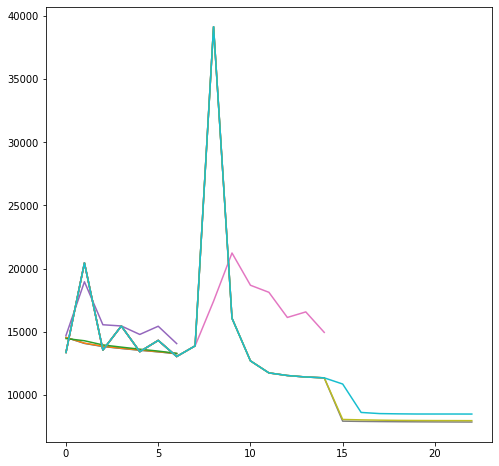

In [14]:
tms = experiment.models
colors = np.linspace(0, 0.65, len(tms))

plt.figure(figsize=(8,8))
for i, tm in enumerate(list(tms.values())[1:]):
    score = tm.scores['PerplexityScore@all']
    plt.plot(score[1:])
plt.show()

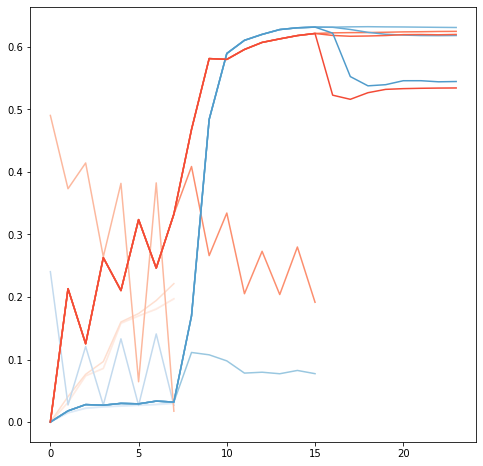

In [19]:
from matplotlib import cm
tms = experiment.models
colors = np.linspace(0, 0.65, len(tms))

plt.figure(figsize=(8,8))
for i, tm in enumerate(list(tms.values())[1:]):
    score = tm.scores['TopicKernel@word.average_purity']
    plt.plot(score, color=cm.Blues(colors[i]))
    score = tm.scores['TopicKernel@word.average_contrast']
    plt.plot(score, color=cm.Reds(colors[i]))
plt.show()

In [21]:
query = (
    "TopicKernel@word.average_contrast > 0.8 * MAXIMUM(TopicKernel@word.average_contrast) "
    "and TopicKernel@word.average_purity > 0.8 * MAXIMUM(TopicKernel@word.average_purity) "
    "and PerplexityScore@all < 1.1 * MINIMUM(PerplexityScore@all) "
)
models = experiment.select(query + " COLLECT all")
def describe_model(model):
    for reg_name, reg in model.regularizers._data.items():
        print(reg_name, reg.tau)
    print(model.scores["PerplexityScore@all"][-1])
    print(model.scores["TopicKernel@word.average_contrast"][-1])
    print(model.scores["TopicKernel@word.average_purity"][-1])
    print("------")
for model in models:
    describe_model(model)

smooth_phi_bcg 0.0
smooth_theta_bcg 0.0
decorrelation_phi_@word 10000000.0
smooth_phi_@word 0
sparse_theta 0
7861.90380859375
0.6249268054962158
0.6311060190200806
------
smooth_phi_bcg 0.0
smooth_theta_bcg 0.0
decorrelation_phi_@word 10000000.0
smooth_phi_@word 0
sparse_theta -0.5
7970.27392578125
0.6199975609779358
0.6182859539985657
------
smooth_phi_bcg 0.0
smooth_theta_bcg 0.0
decorrelation_phi_@word 10000000.0
smooth_phi_@word 0
sparse_theta -1.0
8493.2001953125
0.5343874096870422
0.5446979403495789
------


### Investigate model

In [22]:
best_model = models[-1]

In [24]:
from topicnet.viewers.top_tokens_viewer import TopTokensViewer
from topicnet.viewers.top_documents_viewer import TopDocumentsViewer
from IPython.display import display_html, display
from topicnet.cooking_machine.dataset import get_modality_vw

In [31]:
thresh = 1e-5
demo_data = Dataset(DATASET_PATH)
first_model_top_tok = TopTokensViewer(best_model, num_top_tokens=10, method='phi')
first_model_html =  first_model_top_tok.to_html(first_model_top_tok.view(),thresh=thresh)
first_model_top_doc = TopDocumentsViewer(best_model, dataset=demo_data).view()

In [34]:
n=7
for line, topic_docs in list(zip(first_model_html, first_model_top_doc))[-n:]:
    display_html(line, raw=True)
    for doc_id in topic_docs:
        doc_vw = demo_data.get_vw_document(doc_id).values[0][0]
        doc_title = get_modality_vw(doc_vw, "@title")
        doc_snippet = get_modality_vw(doc_vw, "@snippet")
        display_html(f"<b>{doc_title}</b>", raw=True)

,topic_29 @word
график,0.12431
монитор,0.10533
графика,0.10351
bind,0.08728
улучшение,0.08107
улучшить,0.07111
великобритания,0.06637
собеседование,0.04437
мбитc,0.04156
народный,0.03148


,topic_30 @word


,topic_31 @word
телек,0.06329
беспроводный,0.06272
региональный,0.05576
строительство,0.04947
датацентр,0.04641
корбина,0.04451
санктпетербург,0.04221
инвестиционный,0.03373
квартира,0.0274
стратегия,0.02426


,topic_32 @word
потребность,0.11864
лояльность,0.08109
ценность,0.07571
критерий,0.07479
целевой,0.07255
эмоция,0.07171
экспертный,0.05926
повысить,0.04363
mdash,0.0397
взаимосвязь,0.03642


,topic_33 @word
server,0.00798
you,0.00678
itunes,0.00652
on,0.00631
ms,0.00588
джобс,0.00569
is,0.00546
mozilla,0.00545
office,0.0053
i,0.00526


,topic_34 @word
блогер,0.03187
энергия,0.02586
наука,0.02202
бот,0.02076
вселенная,0.01929
встреча,0.01659
семья,0.01434
великий,0.01416
твой,0.0132
теория,0.01298


,bcg_35 @word
сегмент,0.00051
телевидение,0.00051
штат,0.0005
научный,0.0005
проведение,0.0005
польза,0.0005
зайти,0.00049
куча,0.00049
развиваться,0.00049
голова,0.00049
